# Pump Theory and Performance

First, we will import the necessary packages to solve the problems.

In [1]:
from fluids import friction, core, fittings
from fluids.piping import nearest_pipe
from pyfluids import Fluid, FluidsList, Input
import numpy as np
from scipy.optimize import root_scalar
from plotly.subplots import make_subplots

## 1. Pump analysis using the Euler's equation and velocity triangle 
Given the following data for a centrifugal water pump, estimate 
- the design point discharge
- the power delivered to the water
- the head

Given:
- Radius at inlet and outlet: 0.1m 0.175m
- Blade angle at inlet and outlet: \\(30^o\\), \\(20^o\\)
- Impeller speed: 1440 revolution per min (RPM)
- Impeller width at inlet and outlet: 4.25cm

<p style="text-align: center;">
============== Answer ==============
</p>

Let's assume that there is no rotation in the inlet water. Therefore, the velocity triangle at the inlet will look like following:

<p style="text-align: center;">
  <img src="../docs/src/img/pump_analysis_inlet_triangle1.png" alt="Inlet velocity triangle" width=200>
</p>

Then, the discharge rate can be obtained as such:

Velocities:
	 u1 = 15.08 m/s 
	 v1 = 8.71 m/s


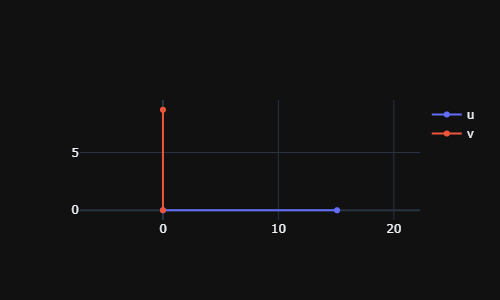

Flow rate: 837.0 m3/h


In [2]:
water = Fluid(FluidsList.Water).with_state(
    Input.pressure(1e5), Input.temperature(20)
)
inlet_impeller_radius_m = 0.10
outlet_impeller_radius_m = 0.175
inlet_blade_angle_deg = 30
outlet_blade_angle_deg = 20
impeller_rotation_speed_rpm = 1440
impeller_width_m = 0.0425

# First convert the values to SI units
impeller_rotation_speed_rad_per_s = 1440 / 60 * 2 * np.pi

# Calculate the velocities
u1 = impeller_rotation_speed_rad_per_s * inlet_impeller_radius_m
v1 = u1 * np.tan(np.deg2rad(inlet_blade_angle_deg))
print(f"Velocities:\n\t u1 = {u1:.2f} m/s \n\t v1 = {v1:.2f} m/s")

# Plot the velocity triangle
def plot_velocity_triangle(u, v, alpha_deg, beta_deg):
    fig = make_subplots()
    fig.add_scatter(x=[0, u], y=[0, 0], name="u")
    alpha_rad = np.deg2rad(alpha_deg)
    fig.add_scatter(x=[0, v * np.cos(alpha_rad)], y=[0, v * np.sin(alpha_rad)], name="v")
    fig.update_layout(height=300, width=500)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.show(renderer="png")

plot_velocity_triangle(
    u=u1, 
    v=v1, 
    alpha_deg=90,
    beta_deg=inlet_blade_angle_deg
)

# Calculate the flow rate
def get_flow_impeller_m3_per_s(radial_velocity_m_per_s, width_m, radius_m):
    return 2 * np.pi * radius_m * width_m * radial_velocity_m_per_s

flow_rate_m3_per_s = get_flow_impeller_m3_per_s(
    radial_velocity_m_per_s=v1,
    width_m=impeller_width_m,
    radius_m=inlet_impeller_radius_m
)
print(f"Flow rate: {flow_rate_m3_per_s * 3600:.1f} m3/h")


The velocity triangle can be drawn for the outlet from the given conditions. The radial velocity \\(V_n2\\) can be determined from flow rate calculated.

<p style="text-align: center;">
  <img src="../docs/src/img/pump_analysis_outlet_triangle1.png" alt="Inlet velocity triangle" width=200>
</p>

Power: 77904.01 W


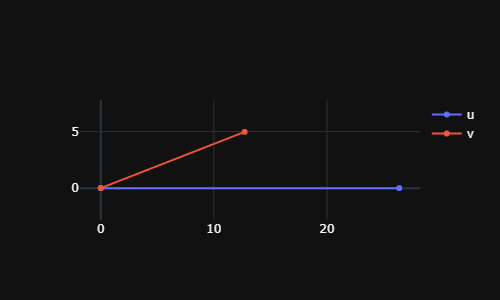

In [3]:
u2 = outlet_impeller_radius_m * impeller_rotation_speed_rad_per_s
area_outlet_m2 = 2 * np.pi * outlet_impeller_radius_m * impeller_width_m
v_n2 = flow_rate_m3_per_s / area_outlet_m2
v_t2 = u2 - v_n2 / np.tan(np.deg2rad(outlet_blade_angle_deg))
power = water.density * flow_rate_m3_per_s * (u2 * v_t2) 
print(f"Power: {power:.2f} W")

alpha = np.degrees(np.arctan(v_n2 / v_t2))
v2 = np.sqrt(v_n2**2 + v_t2**2)
plot_velocity_triangle(u=u2, v=v2, alpha_deg=alpha, beta_deg=outlet_blade_angle_deg)

The head can be estimated the assumption that there is no flow or energy loss in the impeller.

In [4]:
gravitational_acc_m2_per_s = 9.81
head = power / (water.density * gravitational_acc_m2_per_s * flow_rate_m3_per_s)
print(f"Head is {head:.1f} m")

Head is 34.2 m


As we have seen, we usually ignore the tangential velocity of the inlet flow. Then,

$$
P_w = \rho Q u_2 V_{t2}
$$

where

$$
V_{t2} = u_2 - V_{n2} cot \beta_2 \quad V_{n2} = \frac{Q}{2\pi r_2 b_2}
$$

From, the above we get

$$
H\approx \frac{u_2^2}{g} - \frac{u_2 \cot \beta_2}{2 \pi r_2 b_2 g}Q
$$
